# Joined spatial aggregate
## Comparing mobility with handset types
This worked example demonstrates using [joined spatial aggregate](../../../flowclient/flowclient/client/#joined_spatial_aggregate) queries in FlowKit. A joined spatial aggregate query calculates a metric for each subscriber, and joins the metric values to subscribers' locations before aggregating the metric by region.

Suppose we want to investigate whether there is a link between subscribers' mobility and their handset types. We can calculate two joined spatial aggregates:
- Average radius of gyration per region. Radius of gyration is a measure of the spread of a subscriber's event locations - a subscriber with a large radius of gyration will have events spread over a larger area (for example, somebody who commutes over a long distance or regularly travels to regions away from their home).
- Distribution of handset types (basic/feature/smartphone) per region.
Once we have the results of these queries, we can investigate whether there is any correlation between the metrics.

The Jupyter notebook for this worked example can be downloaded [here](https://github.com/Flowminder/FlowKit/raw/master/docs/source/analyst/worked_examples/joined-spatial-aggregate.ipynb), or can be run using the [quick start setup](../../install.md#quickinstall).

### Load FlowClient and connect to FlowAPI
We start by importing FlowClient. We also import [pandas](https://pandas.pydata.org/) and [geopandas](http://geopandas.org/), which we will use for performing further analysis of the outputs from FlowKit.

In [2]:
import os

import pandas as pd
import geopandas as gpd

import flowclient as fc

We must next [generate a FlowAPI access token](../index.md#flowauth) using FlowAuth. If you are running this notebook using the [quick start setup](../../install.md#quickinstall), generating a token requires the following steps:

1. Visit the FlowAuth login page at [http://localhost:9091](http://localhost:9091/).
2. Log in with username `TEST_USER` and password `DUMMY_PASSWORD`.
3. Under \"My Servers\", select `TEST_SERVER`.
4. Click the `+` button to create a new token.
5. Give the new token a name, and click `SAVE`.
6. Copy the token string using the `COPY` button.
7. Paste the token in this notebook as `TOKEN`.

The steps are the same in a production setup, but the FlowAuth URL, login details and server name will differ.

Once we have a token, we can start a connection to the FlowAPI system. If you are connecting to FlowAPI over https (recommended) and the system administrator has provided you with an SSL certificate file, you should provide the path to this file as the `ssl_certificate` argument to `flowclient.connect()` (in this example, you can set the path in the environment variable `SSL_CERTIFICATE_FILE`). If you are connecting over http, this argument is not required.

In [3]:
conn = fc.connect(
    url=os.getenv("FLOWAPI_URL", "http://localhost:9090"),
    token=TOKEN,
    ssl_certificate=os.getenv("SSL_CERTIFICATE_FILE"),
)

/Users/jamesharrison/Repositories/FlowKit/flowclient/flowclient/client.py:230: UserWarning: Communications with this server are NOT SECURE.
  url=url, token=token, api_version=api_version, ssl_certificate=ssl_certificate


### Specify FlowKit queries

Next, we create query specifications for the FlowKit queries we will run.

#### Locations

Joined spatial aggregate queries join a per-subscriber metric to the subscribers' locations, so we need a query that assigns a single location to each subscriber. Here we use a modal location query to estimate subscribers' home locations over the period of interest (first seven days of 2016), at administrative level 3.

In [4]:
date_range = ("2016-01-01", "2016-01-08")
modal_loc = fc.modal_location_from_dates(start_date=date_range[0], end_date=date_range[1], aggregation_unit="admin3", method="last")

#### Radius of gyration

We create a joined spatial aggregate query specification to calculate the average radius of gyration per region, using locations from the modal location query above.

In [5]:
rog_query = fc.radius_of_gyration(start_date=date_range[0], end_date=date_range[1])
jsa_rog_query = fc.joined_spatial_aggregate(locations=modal_loc, metric=rog_query, method="avg")

#### Handset type

Finally, we specify a second joined spatial aggregate query, this time using a `handset` metric with the `"hnd_type"` (handset type) characteristic. The `handset` query will return a categorical variable (handset type is one of "Basic", "Feature" or "Smart"), so we must choose the `"distr"` method for the joined spatial aggregate, to get the distribution of handset types per region.

In [6]:
handset_query = fc.handset(start_date=date_range[0], end_date=date_range[1], characteristic="hnd_type", method="most-common")
jsa_handset_query = fc.joined_spatial_aggregate(locations=modal_loc, metric=handset_query, method="distr")

### Radius of gyration results

Now that we have a FlowClient connection and we have specified our queries, we can run the queries and get the results using FlowClient's `get_result` function. First, we get the results of the radius of gyration query.

In [7]:
rog_results = fc.get_result(connection=conn, query=jsa_rog_query)
rog_results.head()

,pcod,value
0,524 4 11 57,105.684095
1,524 1 03 12,129.327924
2,524 1 03 11,127.186304
3,524 4 12 65,107.566444
4,524 4 10 54,90.875944


The resulting dataframe has two columns: `pcod` (the P-code of each region) and `value` (the average radius of gyration, in km). Later, we will want to join with other results for the same regions, so let's set the `pcod` column as the index. We also rename the `value` column, to give it the more descriptive name `radius_of_gyration`.

In [8]:
rog_results = rog_results.rename(columns={"value": "radius_of_gyration"}).set_index("pcod")
rog_results.head()

,radius_of_gyration
pcod,
524 4 11 57,105.684095
524 1 03 12,129.327924
524 1 03 11,127.186304
524 4 12 65,107.566444
524 4 10 54,90.875944


We can get a summary of the data using the dataframe's `describe` method, and quickly see the distribution of values using `plot.hist`.

In [9]:
rog_results.describe()

,radius_of_gyration
count,42.000000
mean,111.865277
std,20.934204
min,83.577767
25%,94.196072
50%,107.592349
75%,128.115706
max,170.231436


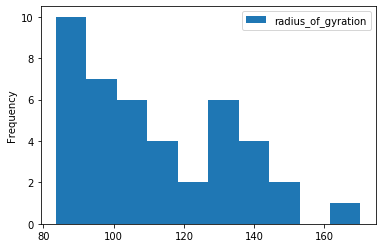

In [10]:
rog_results.plot.hist();

To see the spatial distribution of radius of gyration, we need the geographic boundaries of the administrative regions. We can get these as GeoJSON using the FlowClient `get_geography` function, and load into a GeoPandas `GeoDataFrame` using the `GeoDataFrame.from_features` method.

In [11]:
geog = gpd.GeoDataFrame.from_features(fc.get_geography(connection=conn, aggregation_unit="admin3")).set_index("pcod")

In [12]:
geog.head()

,geometry,centroid
pcod,,
524 2 05 23,"MULTIPOLYGON (((85.96007 27.96835, 85.95963 27...","{'type': 'Point', 'coordinates': [85.739489362..."
524 2 05 24,"MULTIPOLYGON (((85.64439 27.71841, 85.64494 27...","{'type': 'Point', 'coordinates': [85.619344091..."
524 2 05 25,"MULTIPOLYGON (((85.41301 27.60728, 85.41286 27...","{'type': 'Point', 'coordinates': [85.342550173..."
524 2 05 26,"MULTIPOLYGON (((85.51987 27.72881, 85.52070 27...","{'type': 'Point', 'coordinates': [85.440648407..."
524 2 05 27,"MULTIPOLYGON (((85.45037 27.81377, 85.45067 27...","{'type': 'Point', 'coordinates': [85.347212843..."


The `plot` method is a quick way to see the regions described by this GeoDataFrame.

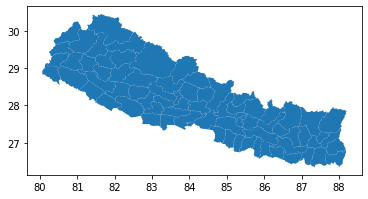

In [13]:
geog.plot();

Now we can join the geography data to the radius of gyration results, and create a choropleth map by plotting again using the `radius_of_gyration` column to colour the regions.  
(Note: the order in which we join here is important - `rog_results.join(geog)` would produce a pandas `DataFrame`, not a geopandas `GeoDataFrame`, and the `plot` method would produce a different plot).

/Users/jamesharrison/.local/share/virtualenvs/flowclient-B4IHfIsc/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


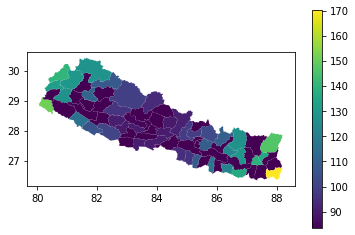

In [14]:
geog.join(rog_results).plot(column="radius_of_gyration", legend=True);

This looks like it worked, but we got a warning: `RuntimeWarning: invalid value encountered in less  xa[xa < 0] = -1`. Looking at the content of the joined dataframe, we can see why:

In [15]:
geog.join(rog_results).head()

,geometry,centroid,radius_of_gyration
pcod,,,
524 2 05 23,"MULTIPOLYGON (((85.96007 27.96835, 85.95963 27...","{'type': 'Point', 'coordinates': [85.739489362...",103.117901
524 2 05 24,"MULTIPOLYGON (((85.64439 27.71841, 85.64494 27...","{'type': 'Point', 'coordinates': [85.619344091...",109.168188
524 2 05 25,"MULTIPOLYGON (((85.41301 27.60728, 85.41286 27...","{'type': 'Point', 'coordinates': [85.342550173...",NaN
524 2 05 26,"MULTIPOLYGON (((85.51987 27.72881, 85.52070 27...","{'type': 'Point', 'coordinates': [85.440648407...",NaN
524 2 05 27,"MULTIPOLYGON (((85.45037 27.81377, 85.45067 27...","{'type': 'Point', 'coordinates': [85.347212843...",NaN


There are some regions for which we have no `radius_of_gyration` data, because these regions contained fewer than 15 subscribers so FlowKit redacted the results to preserve privacy. We can drop these rows using the `dropna` method. So that we can still see the shapes of the regions with no data, let's plot the `geog` data as a light grey background behind our choropleth map.

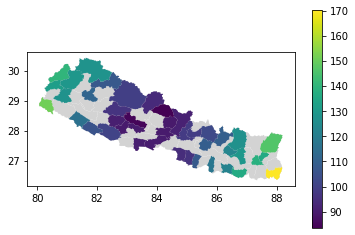

In [16]:
background = geog.plot(color="lightgrey")
geog.join(rog_results).dropna().plot(ax=background, column="radius_of_gyration", legend=True);

### Handset type results
Next we get the results of our handset-type query.

In [22]:
handset_results = fc.get_result(connection=conn, query=jsa_handset_query)
handset_results.head()

,pcod,metric,key,value
0,524 1 01 01,value,Smart,0.313484
1,524 1 01 01,value,Basic,0.340862
2,524 1 01 01,value,Feature,0.345654
3,524 1 01 04,value,Feature,0.351020
4,524 1 01 04,value,Smart,0.307483


This dataframe has four columns: `pcod` (the P-code, as above), `metric`, `key` (the handset type) and `value` (the proportion of subscribers in that region who have that handset type). The `metric` column just contains the value `"value"` in every row, which is not useful to us, so let's drop it. We'll also rename the `key` and `value` columns to `handset_type` and `proportion`, respectively.

This time we have three rows per P-code, one for each handset type, so let's set a `MultiIndex` using the `pcod` and `handset_type` columns.

In [23]:
handset_results = handset_results.rename(columns={"key": "handset_type", "value": "proportion"}).drop(columns="metric").set_index(["pcod", "handset_type"])
handset_results.head()

proportion
pcod        handset_type            
524 1 01 01 Smart           0.313484
            Basic           0.340862
            Feature         0.345654
524 1 01 04 Feature         0.351020
            Smart           0.307483

We can get a summary of the data using the `describe` method, but let's first group by `handset_type` to get a summary per handset type.

In [24]:
handset_results.groupby("handset_type").describe()

proportion                                                    \
                  count      mean       std       min       25%       50%   
handset_type                                                                
Basic              42.0  0.336651  0.014786  0.305132  0.326712  0.339408   
Feature            42.0  0.338004  0.015510  0.307487  0.329857  0.338537   
Smart              42.0  0.325345  0.015310  0.292683  0.314722  0.325667   

                                  
                   75%       max  
handset_type                      
Basic         0.346986  0.371274  
Feature       0.346596  0.369771  
Smart         0.336672  0.353805

Similarly, we can call the `plot.hist` method of the grouped data to produce a histogram for each handset type.

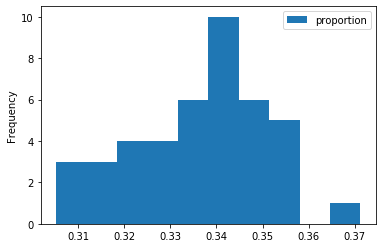

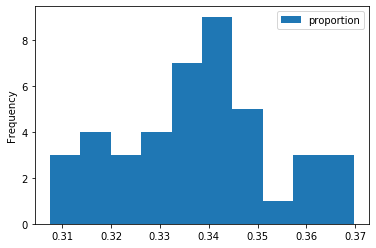

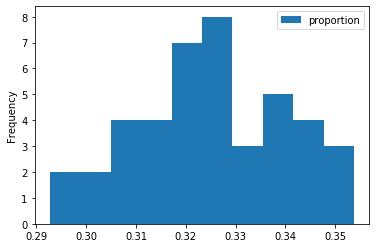

In [25]:
handset_results.groupby("handset_type").plot.hist();

It may be more useful to plot all three histograms on the same axes. This would be the default output from pandas if the proportion data for each handset type were in separate columns. Since we set a hierarchical index on the `handset_results` dataframe, we can use the `unstack` method to unpack the innermost level of the index (`handset_type`, in this case) into separate columns.

In [26]:
handset_results.unstack().head()

proportion                    
handset_type      Basic   Feature     Smart
pcod                                       
524 1 01 01    0.340862  0.345654  0.313484
524 1 01 04    0.341497  0.351020  0.307483
524 1 02 07    0.317872  0.335607  0.346521
524 1 02 08    0.311167  0.343789  0.345044
524 1 03 11    0.306506  0.364856  0.328638

This produces a dataframe with a single-level index, and a `MultiIndex` as column headers. Now the `plot.hist` method plots all three histograms on the same axes. We set `alpha=0.5` to make them slightly transparent. In this dataset we can see that there is little difference between the distributions of the different handset types - the proportions of all handset types are approximately equal in all regions.

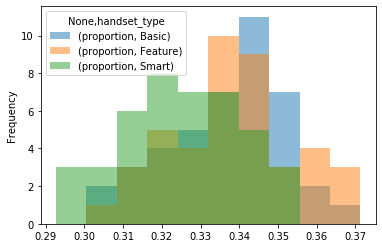

In [27]:
handset_results.unstack().plot.hist(alpha=0.5);

As with the radius of gyration results, we can also join to the geography data and plot choropleth maps of the handset type distributions.

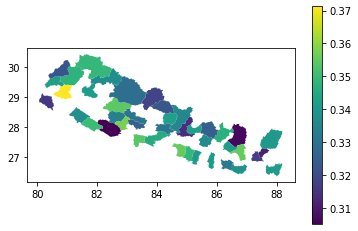

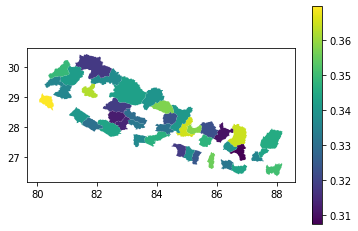

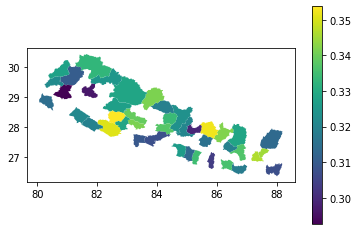

In [28]:
geog.join(handset_results).groupby("handset_type").plot(column="proportion", legend=True);

### Comparing radius of gyration and handset types

#### Join the dataframes
Now that we have the results from both of our joined spatial aggregate queries, we can join them and compare the metrics.

In [29]:
combined = rog_results.join(handset_results.unstack())
combined.head()

/Users/jamesharrison/.local/share/virtualenvs/flowclient-B4IHfIsc/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,radius_of_gyration,"(proportion, Basic)","(proportion, Feature)","(proportion, Smart)"
pcod,,,,
524 4 11 57,105.684095,0.350282,0.330508,0.319209
524 1 03 12,129.327924,0.355615,0.307487,0.336898
524 1 03 11,127.186304,0.306506,0.364856,0.328638
524 4 12 65,107.566444,0.337449,0.337449,0.325103
524 4 10 54,90.875944,0.333778,0.312417,0.353805


#### Correlation
The `corr` method provides a quick way to calculate the correlation between all pairs of columns. We're interested in the correlation between radius of gyration and each of the proportion columns. From these results, there appears to be no significant correlation between handset type and radius of gyration.

In [30]:
combined.corr()

,radius_of_gyration,"(proportion, Basic)","(proportion, Feature)","(proportion, Smart)"
radius_of_gyration,1.000000,-0.070677,0.273707,-0.209038
"(proportion, Basic)",-0.070677,1.000000,-0.490141,-0.469229
"(proportion, Feature)",0.273707,-0.490141,1.000000,-0.539739
"(proportion, Smart)",-0.209038,-0.469229,-0.539739,1.000000


#### Scatter plot
To see whether there is any relationship that's not apparent from the correlation, let's make a scatter plot of radius of gyration against proportion of subscribers who use a smartphone.

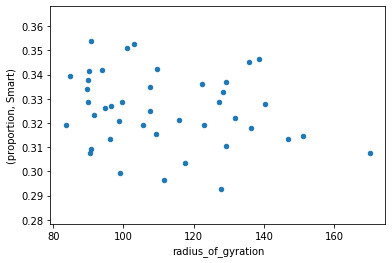

In [31]:
combined.plot.scatter(x="radius_of_gyration", y=("proportion", "Smart"));

We can use `matplotlib` to plot radius of gyration against proportion for each of the handset types on the same plot.

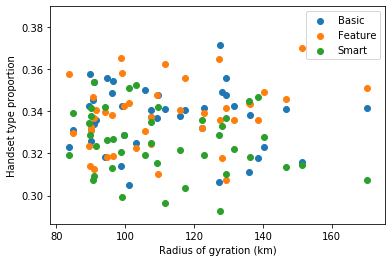

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for htype in ["Basic", "Feature", "Smart"]:
    ax.scatter(combined["radius_of_gyration"], combined[("proportion", htype)], label=htype)
ax.set_xlabel("Radius of gyration (km)")
ax.set_ylabel("Handset type proportion")
ax.legend();

There is no obvious pattern visible in these plots, so for this test dataset we have found no relationship between subscribers' handset types and their radius of gyration.